# 전처리

In [ ]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely

In [ ]:
!pip install imgaug

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [ ]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/인공지능 자연어처리 및 음성인식 음성합성 기술을 활용한 응용 SW 개발자 양성과정 /4.딥러닝_프로젝트/workspace/"

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [ ]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [ ]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
71,v_CricketShot_g18_c03.avi,CricketShot,0
243,v_TennisSwing_g08_c05.avi,TennisSwing,2
257,v_TennisSwing_g10_c06.avi,TennisSwing,2
255,v_TennisSwing_g10_c04.avi,TennisSwing,2
275,v_TennisSwing_g13_c03.avi,TennisSwing,2
...,...,...,...
127,v_Punch_g09_c03.avi,Punch,1
116,v_CricketShot_g25_c06.avi,CricketShot,0
6,v_CricketShot_g08_c07.avi,CricketShot,0
215,v_Punch_g22_c05.avi,Punch,1


In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [ ]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [ ]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
video.shape

(20, 224, 224, 3)

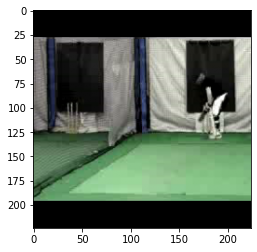

In [ ]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

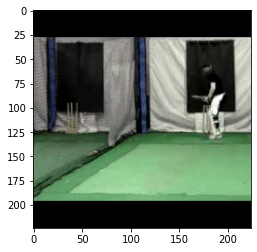

In [ ]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

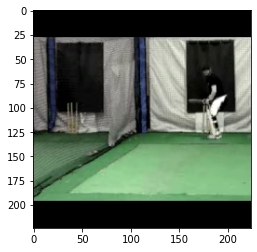

In [ ]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [ ]:
# 비디오 파일 종류 조회
train_df["label"].values

array([0, 2, 2, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 1, 2, 1,
       0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0,
       2, 2, 0, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0, 2, 0,
       0, 1, 2, 2, 1, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1,
       0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 2, 2,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 2, 1,
       1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 0,
       2, 1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 1, 0, 1,
       1, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 2, 2, 0, 0, 1,
       1, 0, 0, 2, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0,
       0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0,
       2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1,
       1, 0, 2, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 1, 1,

In [ ]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[0],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [2],
       [2],
       [1],
       [0],
       [0],
       [0],
       [1],
       [2],
       [2],
       [1],
       [2],
       [1],
       [0],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [1],
       [1],
       [1],
       [2],
       [0],
       [1],
       [1],
       [0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [0],
       [1],
       [1],
       [2],
       [2],
       [1],
       [2],
       [0],
       [2],
       [1],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [1],
       [2],
       [2],
       [1],
       [0],
       [0],
       [2],
       [0],
       [1],
       [0],
       [0],
       [2],
       [1],
       [1],
       [2],
       [1],
    

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [ ]:
# 비디오 프레임을 이미지로 변환한 데이터를 X_train에 저장
# 비디오 프레임 이미지의 종류를 y_train에 저장
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [ ]:
# 전체 비디오 프레임을 이미지로 변환한 데이터 조회
X_train

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [ ]:
X_train.shape

(7120, 224, 224, 3)

In [ ]:
#비디오 종류
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape

(7120, 3)

In [ ]:
X_train[0].shape

(224, 224, 3)

In [ ]:
#0번째 이미지 조회
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

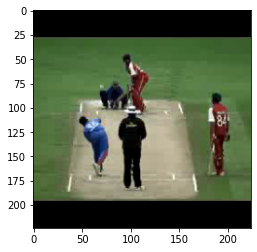

In [ ]:
# 0번째  이미지
plt.imshow(X_train[0]/255)

In [ ]:
# 0번째 이미지 종류
y_train[0]

array([1., 0., 0.], dtype=float32)

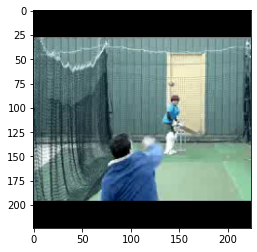

In [ ]:
# 100번째  이미지
plt.imshow(X_train[100]/255)

In [ ]:
# 100번째 이미지 종류
y_train[100]

array([1., 0., 0.], dtype=float32)

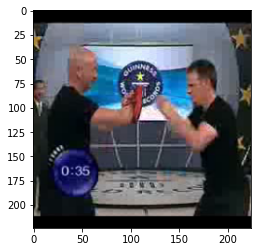

In [ ]:
# 1000 번째 이미지
plt.imshow(X_train[1000]/255)

In [ ]:
# 1000 번째 이미지 종류
y_train[1000]

array([0., 1., 0.], dtype=float32)

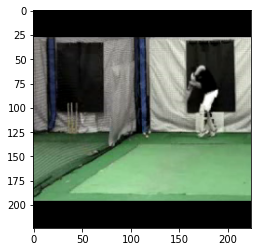

In [ ]:
# 4759 번째  이미지
plt.imshow(X_train[4759]/255)

In [ ]:
# 4759 번째 이미지 종류
y_train[4759]

array([1., 0., 0.], dtype=float32)

# 데이터 증강

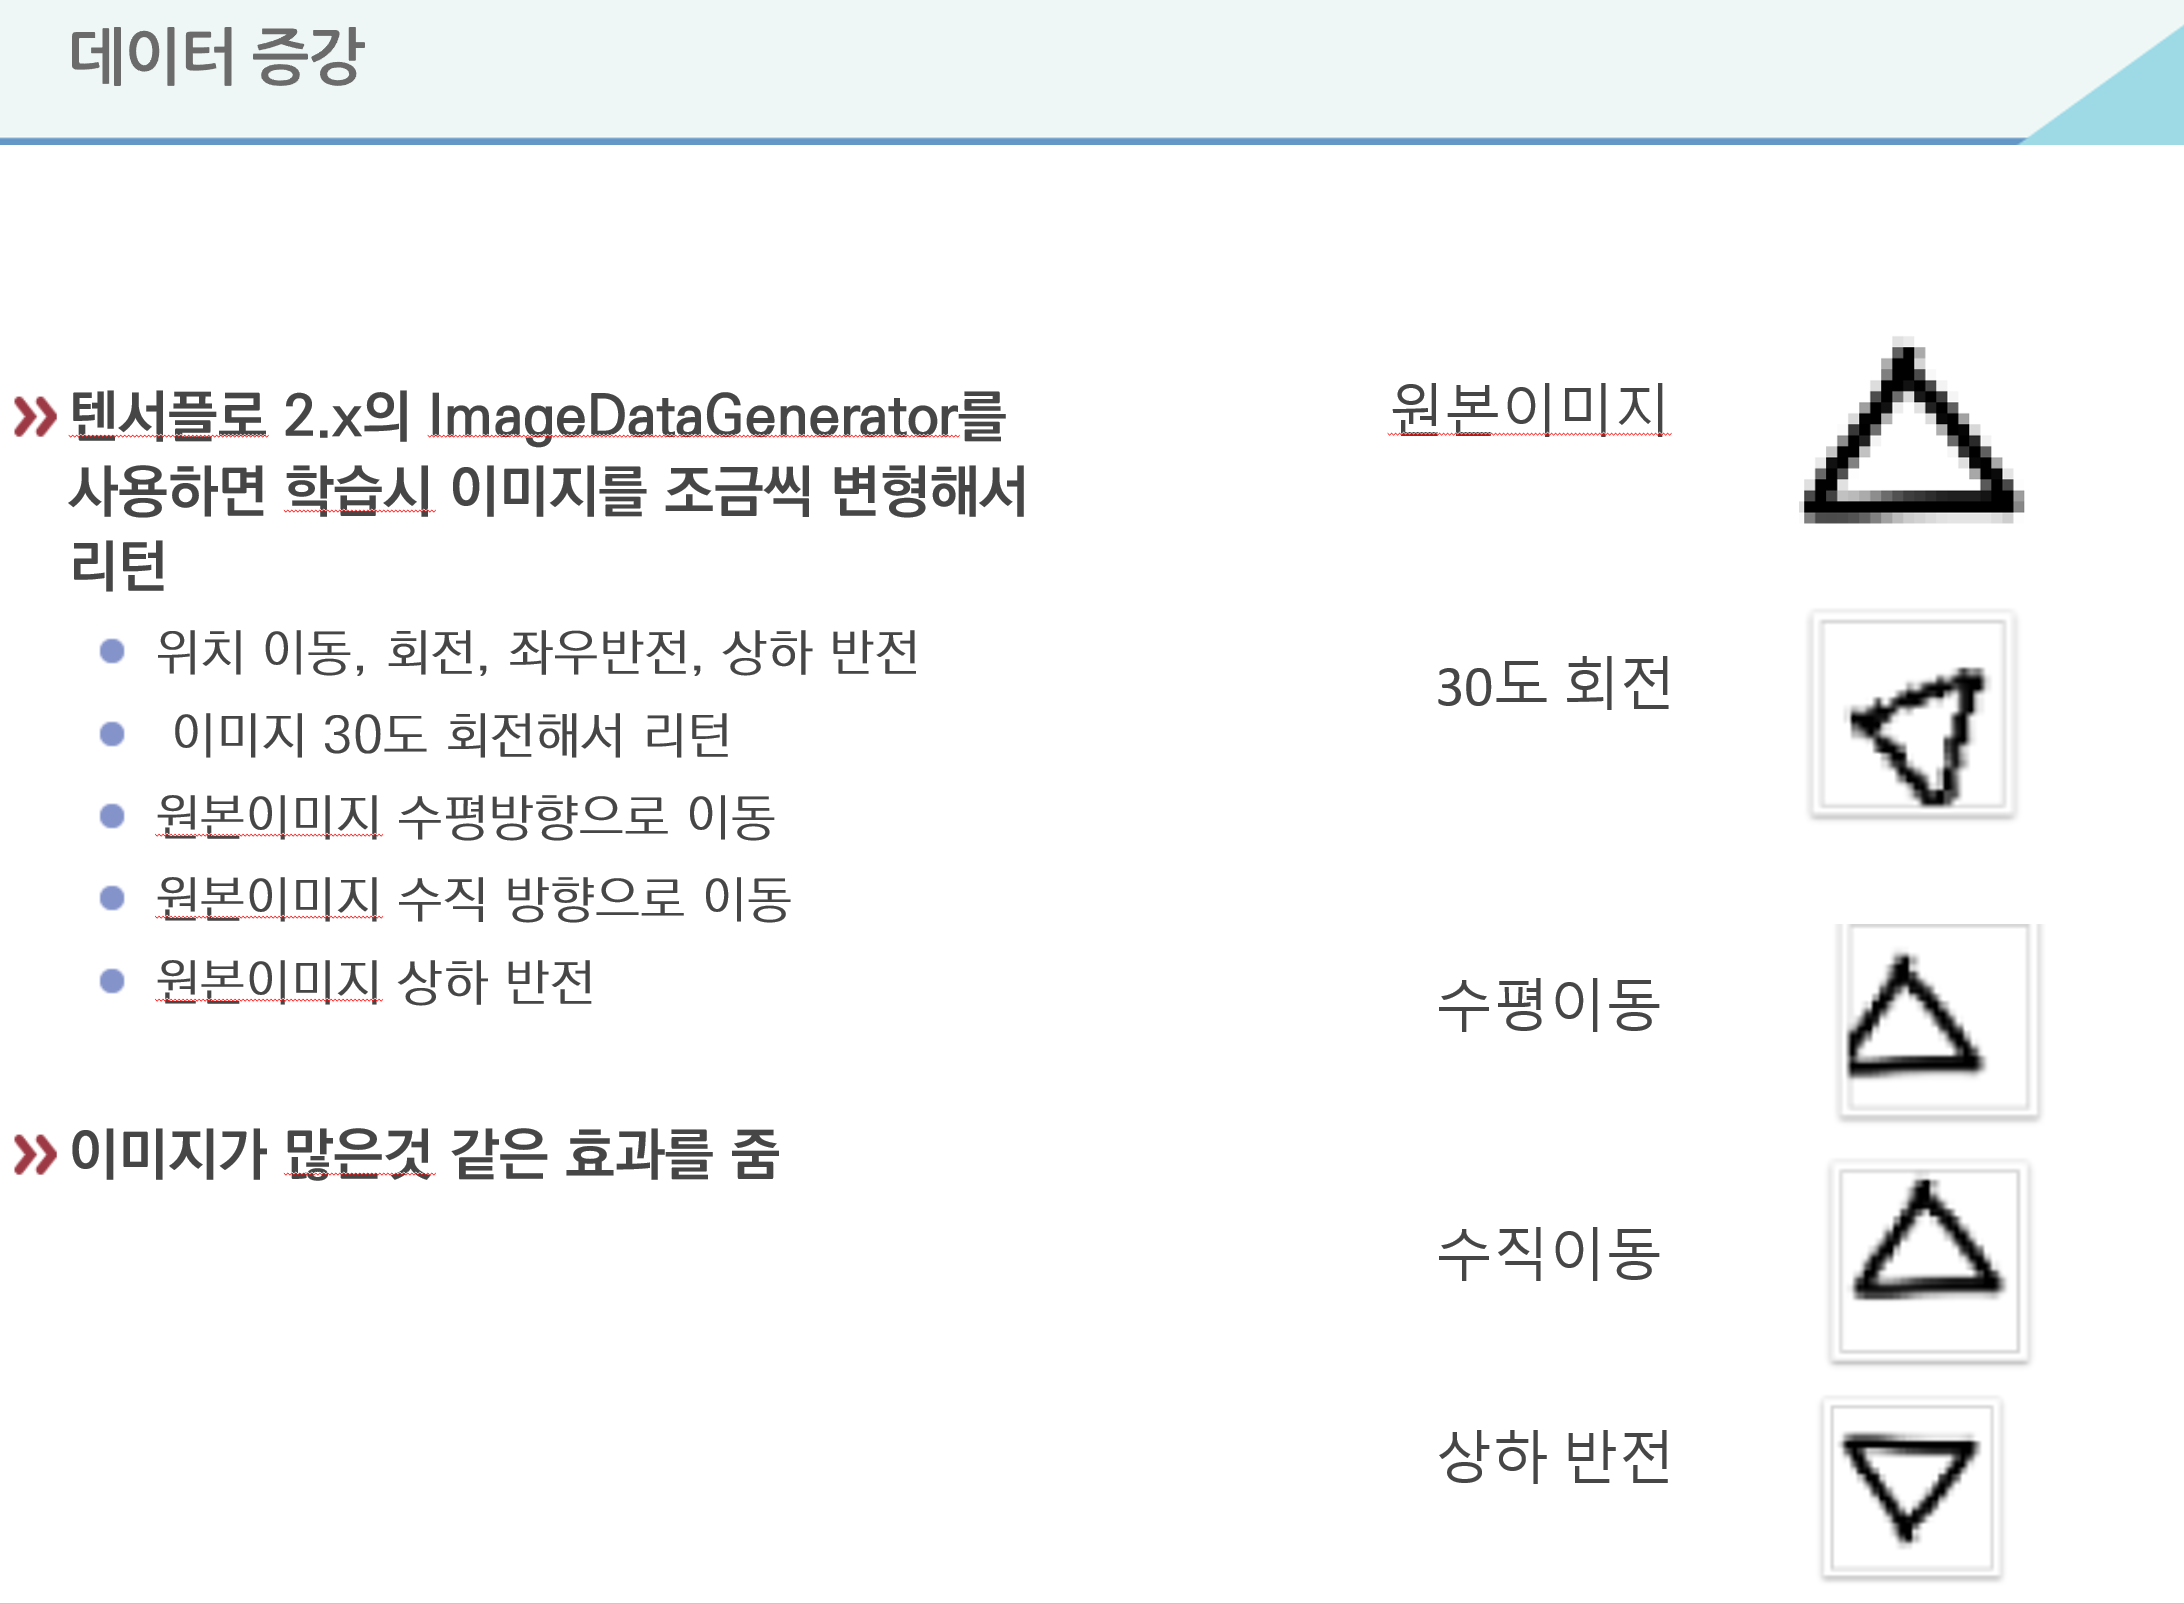

In [ ]:
import imgaug.augmenters as iaa

In [ ]:
import imgaug as ia

In [ ]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [ ]:
seq

Sequential(name=UnnamedSequential, random_order=True, children=[Fliplr(name=UnnamedFliplr, parameters=[Binomial(Deterministic(float 0.50000000))], deterministic=False), Flipud(name=UnnamedFlipud, parameters=[Binomial(Deterministic(float 0.20000000))], deterministic=False), Sometimes(p=Binomial(Deterministic(float 0.50000000)), name=UnnamedSometimes, then_list=Sequential(name=UnnamedSometimes-then, random_order=False, children=[CropAndPad(name=UnnamedCropAndPad, parameters=[Uniform(Deterministic(float -0.05000000), Deterministic(float 0.10000000)), None, None, None, None, Choice(a=['maximum', 'linear_ramp', 'wrap', 'constant', 'median', 'mean', 'edge', 'symmetric', 'reflect', 'minimum'], replace=True, p=None), DiscreteUniform(Deterministic(int 0), Deterministic(int 255))], deterministic=False)], deterministic=False), else_list=None, deterministic=False), Sometimes(p=Binomial(Deterministic(float 0.50000000)), name=UnnamedSometimes, then_list=Sequential(name=UnnamedSometimes-then, random_

In [ ]:
import math

In [ ]:
# 이미지를 증강시켜서 배치 사이즈 만큼씩 리턴하는 클래스 구현

class  ImageSequence(tf.keras.utils.Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # image_arr : 이미지가 저장된 배열
    # label_arr : 이미지의 종류가 저장된 배열
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
    # seq : 이미지 증강 객체

    def __init__(self, image_arr ,label_arr, batch_size, seq):
        # 매개변수들을 속성에 저장
        self.image_arr  = image_arr 
        self.label_arr = label_arr
        self.batch_size = batch_size
        self.seq = seq
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # image_arr  (이미지가 저장된 배열) / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(len(self.image_arr ) / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 리턴
        batch_image_arr = self.image_arr[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 증강시키기 위해서 batch_image_arr을 정수로 변환
        img = np.array( batch_image_arr,  dtype=np.uint8)
        # img를 증강시켜서 generate_img에 저장
        generate_img = seq(images=img) 
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 이미지 종류 리턴
        batch_label_arr = self.label_arr[idx * self.batch_size:(idx + 1) * self.batch_size]

        return generate_img/255.0, batch_label_arr
        

# 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
#모델을 생성해서 리턴하는 함수
def build_model(learning_rate, dropout_rate):
    #입력값을 읽어서 예측을 할 Sequential 객체 생성
    model = Sequential()
    #Conv2D() :합성곱 연산을 수행

    #Conv2D(필터개수, kernel_size=(필터줄, 필터칸), input_shape=(이미지줄, 이미지칸, 컬러3 흑백1 ),
    #       activation='활성함수', padding="SAME")
    #Conv2D(32, kernel_size=(3, 3), input_shape=(224, 224, 3),activation='relu', padding="SAME") 

    #필터 개수 : 32
    #필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
    #입력 이미지 : input_shape=(224, 224, 3) 가로 224 세로 224 컬러
    #활성 함수: activation='relu' 활성함수 relu 사용
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

    model.add(Conv2D(32, kernel_size=(3, 3),  input_shape=(224, 224, 3),activation='relu', padding="SAME"))

    #MaxPooling2D()맥스 풀링 연산을 수행 
    #pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
    model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

    #Conv2D() :합성곱 연산을 수행

    #Conv2D(필터개수, kernel_size=(필터줄, 필터칸),strides=이동칸수, activation='활성함수', padding="SAME")
    #Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME")

    #필터 개수 : 64
    #필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
    #활성 함수: activation='relu' 활성함수 relu 사용
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME"))

    #MaxPooling2D()맥스 풀링 연산을 수행 
    #pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
    model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

    #Conv2D() :합성곱 연산을 수행

    #Conv2D(필터개수, kernel_size=(필터줄, 필터칸),strides=이동칸수, activation='활성함수', padding="SAME")
    #Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME")

    #필터 개수 : 128
    #필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
    #활성 함수: activation='relu' 활성함수 relu 사용
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

    model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding="SAME"))

    #MaxPooling2D()맥스 풀링 연산을 수행 
    #pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
    #padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
    model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

    #전체 데이터 중 50%에 대해서만 기울기를 계산해서 수정
    model.add(Dropout(dropout_rate))

    #선형 회귀를 하기 위해서 합성곱 연산을 수행한 결과를 1차원 배열로 변환
    model.add(Flatten())

    #Dense : 선형 회귀를 수행할 객체
    #Dense(출력데이터의 칸의수) : 출력 데이터의 칸의 수는 256 이므로
    #Dense(256)  
    # activation="relu" :선형 회귀 후 relu 활성 함수 사용
    #model.add(Dense(nodes, activation='relu')) :Dense 모델을 예측 할 수 있도록 model에 추가
    model.add(Dense(256, activation='relu'))

    #전체 데이터 중 20%에 대해서만 기울기를 계산해서 수정
    model.add(Dropout(0.8))

    #Dense : 선형 회귀를 수행할 객체
    #Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 3이므로
    #Dense(3)

    #Dense(3) : 선형 회귀를 할 객체를 생성  출력 칸수는 3
        
    # activation="softmax" :선형 회귀 후 softmax 함수를 활성 함수를 이용해서 다중분루  
        
        
    #model.add(Dense(3, activation="softmax")):Dense 모델을 예측 할 수 있도록 model에 추가
    model.add(Dense(3, activation="softmax"))

    #GradientDecnet를 이용해서 w1,w2,w3,w4를 찾는 방법을 설정함
    #loss='categorical_crossentropy' : -(y * tf.log(hypothesis1)) 합 이 최소가 되는 w1,w2,w3,w4 를 찾음
    #optimizer=Adam(lr=learning_rate) : learning rate를 파라메터 값으로 설정
    model.compile(
                    loss="categorical_crossentropy", 
                    optimizer=Adam(lr=learning_rate),
                    metrics=["acc"]
                )
    # 생성한 모델 리턴
    return model


# GridSearchCV로 최적의 파라메터 찾기

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# GridSearchCV 최적의 파라메터를 찾을때 사용하는 메서드 들이 구현된 클래스
class ImageKerasClassifier(KerasClassifier):
    # GridSearchCV 가 학습할때 호출되는 함수
    def fit(self, X, y, **kwargs):
        print("\n\n")
        print("="*100)
        print("Image Keras Classifier fit call")
        print("="*100)
        print("self.sk_params = ", self.sk_params, " 학습 (전체 데이터 80%)")
        print("="*100)
        print("="*100)
        
        # build_fn에 설정된 함수(케라스 모델 리턴)를 실행해서 모델 리턴
        self.model = self.build_fn(
                    # 파라메터 learning_rate 중 하나가 선택됨
                    learning_rate = self.sk_params["learning_rate"] ,
                    # 파라메터 dropout_rate 중 하나가 선택됨
                    dropout_rate = self.sk_params["dropout_rate"]
                    )
    
        # ImageSequence : 객체 생성
        # X : 이미지
        # y : 이미지 라벨
        # 32 : 배치 사이즈
        #seq : 이미지 증강 객체
        train_sequence = ImageSequence(
                            X, y, 32, seq)

        # 이미지 학습
        self.model.fit(
            #train_sequence가 리턴하는 증강된 이미지를 학습  
            train_sequence,
            epochs = 5 )                    
        return self
    
    # GridSearchCV가 성능측정시 사용되는 함수
    # 이 함수에서 리턴한 정확도가 가장 높은 파라메터가 선택됨
    def score(self, X, y, **kwargs):
        print("*"*100)
        print("*"*100)
        print("Image Keras Classifier score call")
        print("학습 안한 20% 데이터로 성능 테스트")
        # 성능 측정해서 측정된 값을 리턴
        outputs = self.model.evaluate(X, y, **kwargs)
        print("테스트 결과 outputs [loss, acc] = ", outputs)
        print("*"*100)
        print("*"*100)
        # 성능 측정값이 저장된 outputs[0]은 loss, outputs[1] 은 정확도
        # 정확도를 리턴함
        return outputs[1]

In [ ]:
# keras.wrapper를 활용하여 분류기
grid_model = ImageKerasClassifier(build_fn = build_model , verbose=0)


In [ ]:
# 성능 측정을 하고 싶은 파라메터를 설정
# 여러가지 값들로 설정 가능
param = dict(               
                  learning_rate = [1e-3, 1e-4], # learning_rate 설정 (여러개 설정 가능)
                  dropout_rate = [0.5 , 0.8])   # droupout_rate 설정 (여러개 설정 가능)

In [ ]:
param

{'dropout_rate': [0.5, 0.8], 'learning_rate': [0.001, 0.0001]}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# 최적의 파라메터를 조회하는 GridSearchCV
# 5-Fold로 학습을 진행함 
# estimator : ImageKerasClassifier (성능 측정시 실행할 메서드 구현)
# param_grid : 성능 측정하고 싶은 파라메터
# refit = False : 성능 측정이 끝난 모델들을 메모리에서 삭제해서 메모리 절약
# refit = True : 성능 측정이 끝난 모델들을 메모리에서 삭제하지 않고 메모리에 계속 저장하고 있음
grid = GridSearchCV(estimator=grid_model, param_grid=param, refit=False)

In [ ]:
# 최적의 파라메터를 찾아줌
# 전체 중에서 500 개의 이미지만 실행 => 실제는 전체 데이터로 실행해야 함
grid_result = grid.fit(X_train[0:500], y_train[0:500])




Image Keras Classifier fit call
self.sk_params =  {'verbose': 0, 'dropout_rate': 0.5, 'learning_rate': 0.001}  학습 (전체 데이터 80%)
Epoch 1/5
13/13 [==============================] - 8s 442ms/step - loss: 2.8992 - acc: 0.2425
Epoch 2/5
13/13 [==============================] - 7s 528ms/step - loss: 1.0988 - acc: 0.4075
Epoch 3/5
13/13 [==============================] - 9s 701ms/step - loss: 1.1068 - acc: 0.3900
Epoch 4/5
13/13 [==============================] - 8s 586ms/step - loss: 1.0587 - acc: 0.4700
Epoch 5/5
13/13 [==============================] - 8s 623ms/step - loss: 0.9839 - acc: 0.5350
****************************************************************************************************
****************************************************************************************************
Image Keras Classifier score call
학습 안한 20% 데이터로 성능 테스트
4/4 [==============================] - 0s 22ms/step - loss: 66.5548 - acc: 0.6000
테스트 결과 outputs [loss, acc] =  [66.55477905273438, 0.60000002

In [ ]:
# 최적의 파라메터 조회
grid_result.best_params_

{'dropout_rate': 0.8, 'learning_rate': 0.0001}